In [1]:
%load_ext autoreload

In [131]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from kneed import KneeLocator
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, filtfilt, freqz
from sklearn.linear_model import LinearRegression
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from multiproc import compute_correlations
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compile_folder, get_data_class, get_result_path, load, run_window_selection, t_test_two_sample, save, to_string

## See if all sessions have finished

In [59]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = 'propofolPuffTone'
# data_class = 'leverOddball'

In [60]:
sessions = [filename[:-4] for filename in os.listdir(os.path.join(all_data_dir, data_class)) if filename.endswith('.mat')]

In [61]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.5, 0.5)]

In [62]:
# bandpass_info = {'flag': False, 'low': 0.5, 'high': 100}

In [63]:
results_dir = os.path.join(f'/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR')
finished_sessions = []
if data_class == 'propofolPuffTone':
    num_areas = 5
elif data_class == 'leverOddball':
    num_areas = 5
for session in tqdm(sessions):
    finished_windows = []
    for window in windows:
        result_path = None
        try:
            result_path = get_result_path(results_dir, session, window)
        except Exception as e:
            print(e)
#             tb.print_exception(e)
        if result_path is not None:
            if len(os.listdir(result_path)) != num_areas:
                print(f"Session {session} window {window} only has {os.listdir(result_path)}")
            else:
                missing_areas = []
                for area in os.listdir(result_path):
                    if os.path.isdir(os.path.join(result_path, area)):
                        if len(os.listdir(os.path.join(result_path, area))) == 0:
                            missing_areas.append(area)
                if len(missing_areas) > 0:
                    print(f"Missing session {session} window {window} areas {missing_areas}")
                else:
                    finished_windows.append(window)
        
    if len(finished_windows) == len(windows):
        finished_sessions.append(session)

  0%|          | 0/21 [00:00<?, ?it/s]

In [64]:
finished_sessions

['MrJones-Anesthesia-20160105-01',
 'Mary-Anesthesia-20160818-02',
 'Mary-Anesthesia-20160912-02',
 'Mary-Anesthesia-20160902-02',
 'MrJones-Anesthesia-20160121-01',
 'Mary-Anesthesia-20160809-01',
 'MrJones-Anesthesia-20160113-01',
 'MrJones-Anesthesia-20160109-01',
 'MrJones-Anesthesia-20160210-01',
 'MrJones-Anesthesia-20160123-01',
 'Mary-Anesthesia-20160826-02',
 'MrJones-Anesthesia-20160125-01',
 'MrJones-Anesthesia-20160301-01',
 'MrJones-Anesthesia-20160201-01',
 'MrJones-Anesthesia-20160107-01',
 'Mary-Anesthesia-20160914-02',
 'MrJones-Anesthesia-20160206-01',
 'Mary-Anesthesia-20160822-02',
 'Mary-Anesthesia-20160831-02',
 'Mary-Anesthesia-20160908-02',
 'Mary-Anesthesia-20160916-02']

# Run Window Selection

In [65]:
pred_steps = 10
pct_of_value = 0.95

In [66]:
VAR_results, window_selection_info = {}, {}
for session in finished_sessions:
    print("="*20)
    print(f"SESSION = {session}")
    print("-"*20)
    run_window_selection(session, pred_steps=pred_steps, pct_of_value=pct_of_value)

SESSION = MrJones-Anesthesia-20160105-01
--------------------
VAR results with selected windows found for session MrJones-Anesthesia-20160105-01.
Window selection info found for session MrJones-Anesthesia-20160105-01.
SESSION = Mary-Anesthesia-20160818-02
--------------------
VAR results with selected windows found for session Mary-Anesthesia-20160818-02.
Window selection info found for session Mary-Anesthesia-20160818-02.
SESSION = Mary-Anesthesia-20160912-02
--------------------
VAR results with selected windows found for session Mary-Anesthesia-20160912-02.
Window selection info found for session Mary-Anesthesia-20160912-02.
SESSION = Mary-Anesthesia-20160902-02
--------------------
VAR results with selected windows found for session Mary-Anesthesia-20160902-02.
Window selection info found for session Mary-Anesthesia-20160902-02.
SESSION = MrJones-Anesthesia-20160121-01
--------------------
VAR results with selected windows found for session MrJones-Anesthesia-20160121-01.
Window se

# Plot

In [166]:
finished_sessions

['MrJones-Anesthesia-20160105-01',
 'Mary-Anesthesia-20160818-02',
 'Mary-Anesthesia-20160912-02',
 'Mary-Anesthesia-20160902-02',
 'MrJones-Anesthesia-20160121-01',
 'Mary-Anesthesia-20160809-01',
 'MrJones-Anesthesia-20160113-01',
 'MrJones-Anesthesia-20160109-01',
 'MrJones-Anesthesia-20160210-01',
 'MrJones-Anesthesia-20160123-01',
 'Mary-Anesthesia-20160826-02',
 'MrJones-Anesthesia-20160125-01',
 'MrJones-Anesthesia-20160301-01',
 'MrJones-Anesthesia-20160201-01',
 'MrJones-Anesthesia-20160107-01',
 'Mary-Anesthesia-20160914-02',
 'MrJones-Anesthesia-20160206-01',
 'Mary-Anesthesia-20160822-02',
 'Mary-Anesthesia-20160831-02',
 'Mary-Anesthesia-20160908-02',
 'Mary-Anesthesia-20160916-02']

In [173]:
# session = 'SPOCK_Ketamine_20210909'
session = finished_sessions[2]

In [174]:
VAR_results, window_selection_info = run_window_selection(session, return_data=True)

VAR results with selected windows found for session Mary-Anesthesia-20160912-02.
Window selection info found for session Mary-Anesthesia-20160912-02.


In [175]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
filename = f"/om/user/eisenaj/datasets/anesthesia/mat/{data_class}/{session}.mat"
print("Loading data ...")
start = time.process_time()
electrode_info, lfp_schema, session_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo'], verbose=False)
if session in ['MrJones-Anesthesia-20160201-01', 'MrJones-Anesthesia-20160206-01', 'MrJones-Anesthesia-20160210-01']:
    electrode_info['area'] = np.delete(electrode_info['area'], np.where(np.arange(len(electrode_info['area'])) == 60))
elif data_class == 'leverOddball':
    electrode_info['area'] = np.array([f"{area}-{h[0].upper()}" for area, h in zip(electrode_info['area'], electrode_info['hemisphere'])])
T = len(lfp_schema['index'][0])
N = len(lfp_schema['index'][1])
dt = lfp_schema['smpInterval'][0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 1.71 seconds)


In [176]:
area = 'vlPFC'
anesthesia_start_ind = np.argmax(VAR_results[area]['start_time'] > session_info['drugStart'][0])
LOC_ind = np.argmax(VAR_results[area]['start_time'] > session_info['eyesClose'])
anesthesia_end_ind = np.argmax(VAR_results[area]['start_time'] > session_info['drugEnd'][1])

In [164]:
# wake_inds = np.hstack(VAR_results[area][:anesthesia_start_ind].criticality_inds.to_numpy())
# anesthesia_inds = np.hstack(VAR_results[area][LOC_ind:anesthesia_end_ind].criticality_inds.to_numpy())
wake_inds = np.hstack(VAR_results[area][:anesthesia_start_ind].criticality_inds.apply(lambda x: x.mean()).to_numpy())
anesthesia_inds = np.hstack(VAR_results[area][LOC_ind:anesthesia_end_ind].criticality_inds.apply(lambda x: x.mean()).to_numpy())

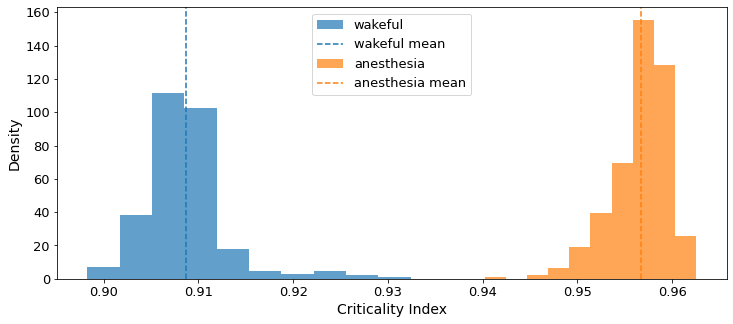

In [165]:
plt.figure(figsize=(12, 5))
plt.hist(wake_inds, label='wakeful', density=True, alpha=0.7)
plt.axvline(wake_inds.mean(), c='C0', linestyle='--', label='wakeful mean')
plt.hist(anesthesia_inds, label='anesthesia', density=True, alpha=0.7)
plt.axvline(anesthesia_inds.mean(), c='C1', linestyle='--', label='anesthesia mean')
plt.legend(fontsize=13)
plt.ylabel("Density", fontsize=14)
plt.xlabel("Criticality Index", fontsize=14)
plt.tick_params(labelsize=13)
plt
plt.show()

In [113]:
scipy.stats.t.ppf(0.95, df)

1.6463743261039119

In [111]:
t_stat, df, p

(244.95013308437845, 1002.9506149337398, 0.0)

In [155]:
destab_inds = VAR_results[area][anesthesia_start_ind:LOC_ind].criticality_inds.apply(lambda x: x.mean()).to_numpy()

time_vals = VAR_results[area][anesthesia_start_ind:LOC_ind].start_time.to_numpy().reshape(-1, 1)
lr_fit = LinearRegression().fit(time_vals, destab_inds)
rate_1 = lr_fit.coef_[0]*1000

rate_2 = (destab_inds[-1] - destab_inds[0])/(VAR_results[area]['start_time'].iloc[LOC_ind] - VAR_results[area]['start_time'].iloc[anesthesia_start_ind])*1000

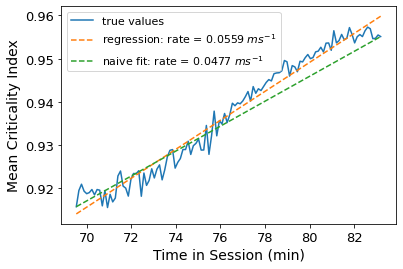

In [161]:
plt.plot(time_vals/60, destab_inds, label='true values')
plt.plot(time_vals/60, lr_fit.predict(time_vals), label=f'regression: rate = {rate_1:.4f}' + r' $ms^{-1}$', linestyle='--')
plt.plot(time_vals/60, np.linspace(destab_inds[0], destab_inds[-1], len(time_vals)), label=f'naive fit: rate = {rate_2:.4f}' + r' $ms^{-1}$', linestyle='--')
plt.xlabel("Time in Session (min)", fontsize=14)
plt.ylabel("Mean Criticality Index", fontsize=14)
plt.tick_params(labelsize=13)
plt.legend(fontsize=11)
plt.show()

In [150]:
VAR_results[area][:anesthesia_start_ind].criticality_inds.apply(lambda x: x.mean()).to_numpy()

array([0.90209207, 0.89949873, 0.90403372, ..., 0.90505918, 0.90543462,
       0.91973554])

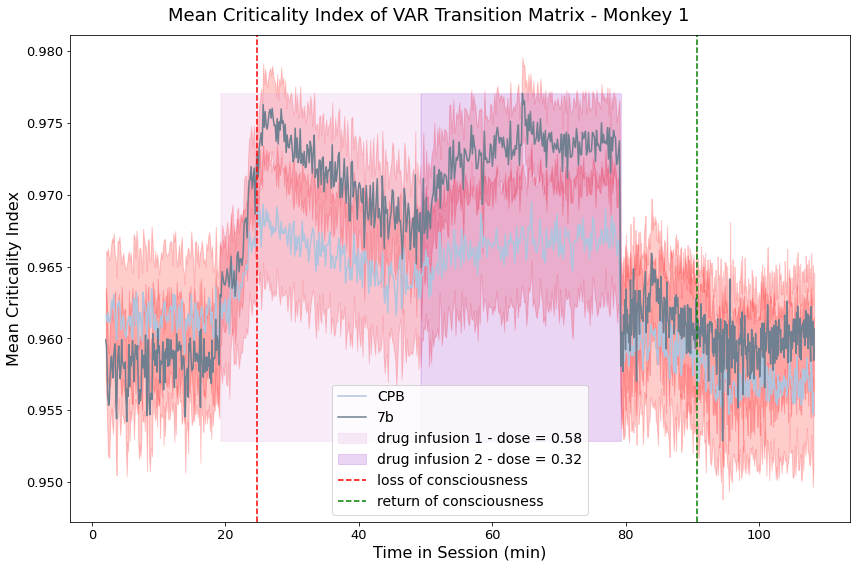

In [178]:
plot_individual_areas(session, data_class, VAR_results, session_info, start_time=125, end_time=None)

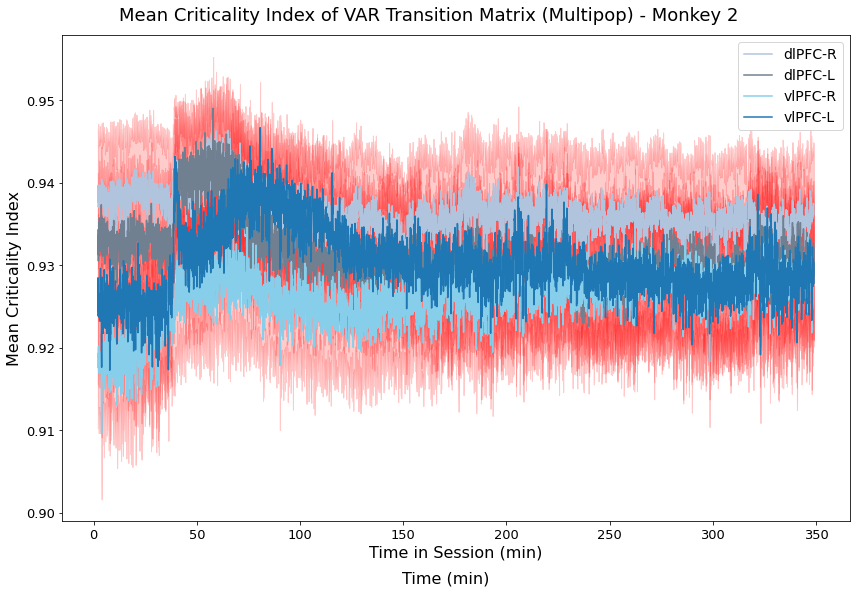

In [58]:
plot_multipopulation(session, data_class, VAR_results, session_info, electrode_info, start_time=125, end_time=None)